In [2]:
# installation
# activate pst_env environment

# import packages and data

import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank

!pip install moscot

from moscot.problems.time import TemporalProblem

import cellrank as cr
import scanpy as sc
from cellrank.kernels import RealTimeKernel

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

  Obtaining dependency information for moscot from https://files.pythonhosted.org/packages/35/f3/30a9eebe206fae868af627664255587e9270d5fc596faa1bb725b8ea2363/moscot-0.3.3-py3-none-any.whl.metadata
  Obtaining dependency information for pandas>=2.0.1 from https://files.pythonhosted.org/packages/2f/0e/3b74e8f7c908082793adafb02753477f653ccd7e189f3ba070757d2d0e65/pandas-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for ott-jax>=0.4.3 from https://files.pythonhosted.org/packages/2a/80/00f56eb884fc1f975a5644f6245d211ed34bb52e1a71364871a77eaa2388/ott_jax-0.4.4-py3-none-any.whl.metadata
  Obtaining dependency information for cloudpickle>=2.2.0 from https://files.pythonhosted.org/packages/96/43/dae06432d0c4b1dc9e9149ad37b4ca8384cf6eb7700cd9215b177b914f0a/cloudpickle-3.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.20.0 from https://files.pythonhosted.org/packages/10/be/ae5bf4737cb79ba437879915791f6f26d

In [3]:
# import data
import warnings

warnings.simplefilter("ignore", category=UserWarning)

adata = cr.datasets.reprogramming_schiebinger(subset_to_serum=True)
adata

100%|██████████| 3.59G/3.59G [02:16<00:00, 28.2MB/s] 


AnnData object with n_obs × n_vars = 165892 × 19089
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch'
    var: 'highly_variable', 'TF'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'
    obsp: 'transition_matrix'

In [4]:
# Massage the time point annotations
adata.obs["day"] = adata.obs["day"].astype(float).astype("category")

# In addition, it's nicer for plotting to have numerical values.
adata.obs["day_numerical"] = adata.obs["day"].astype(float)

In [5]:
# Subsample to speed up the analysis
sc.pp.subsample(adata, fraction=0.25, random_state=0)
adata

AnnData object with n_obs × n_vars = 41473 × 19089
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch', 'day_numerical'
    var: 'highly_variable', 'TF'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'
    obsp: 'transition_matrix'

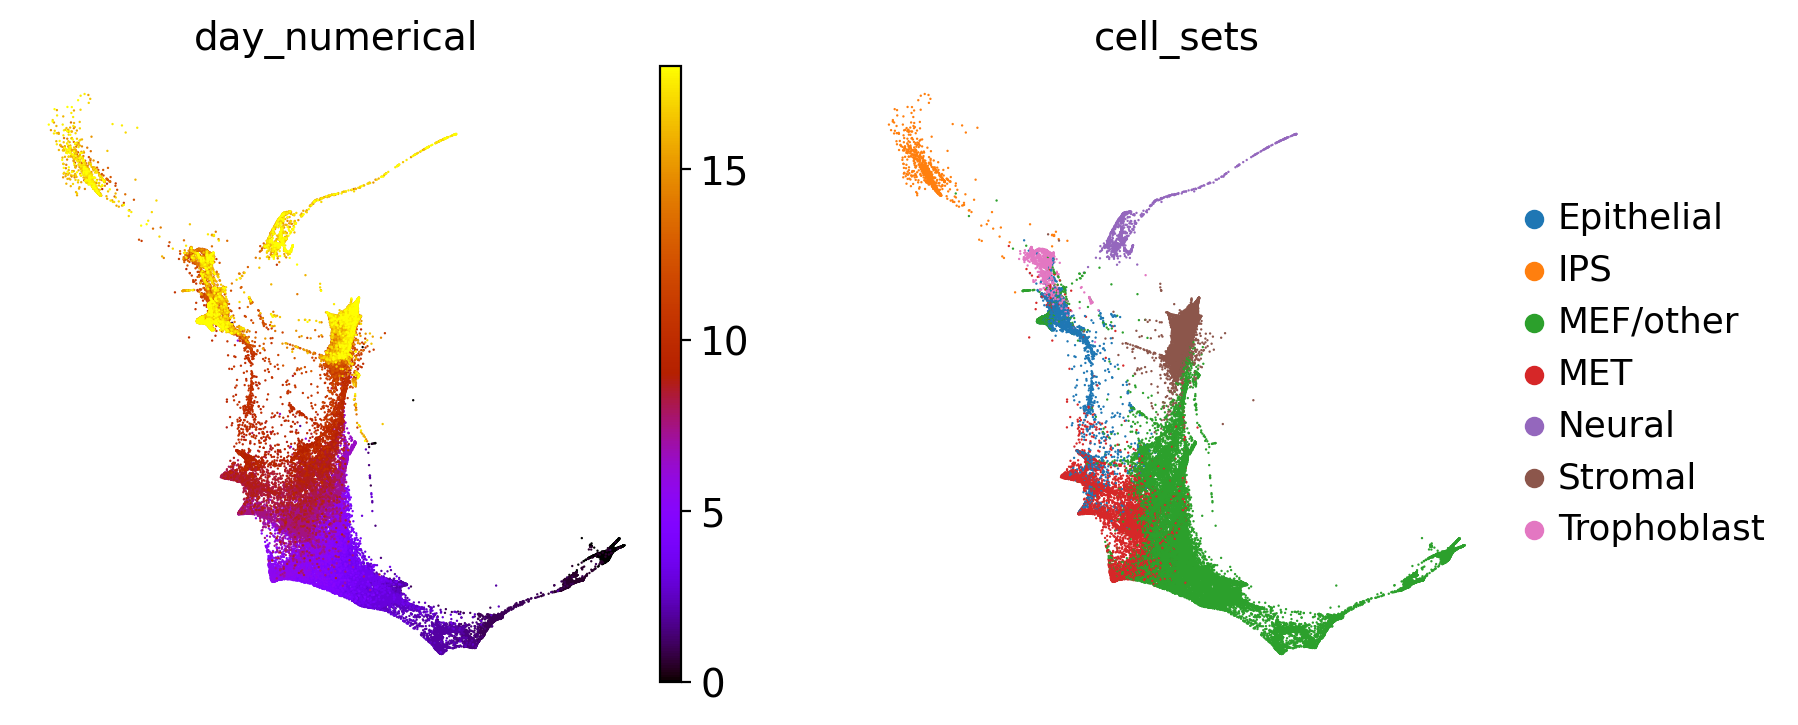

In [6]:
# Let’s visualize this data, using the original force-directede layout

sc.pl.embedding(
    adata,
    basis="force_directed",
    color=["day_numerical", "cell_sets"],
    color_map="gnuplot",
)

In [7]:
# Preprocess the data

# This dataset has already been normalized by total counts and log2-transformed. Further, highly variable genes have already been annotated. 
# We can thus direclty compute a PCA representation and a k-NN graph.

sc.pp.pca(adata)
sc.pp.neighbors(adata, random_state=0)

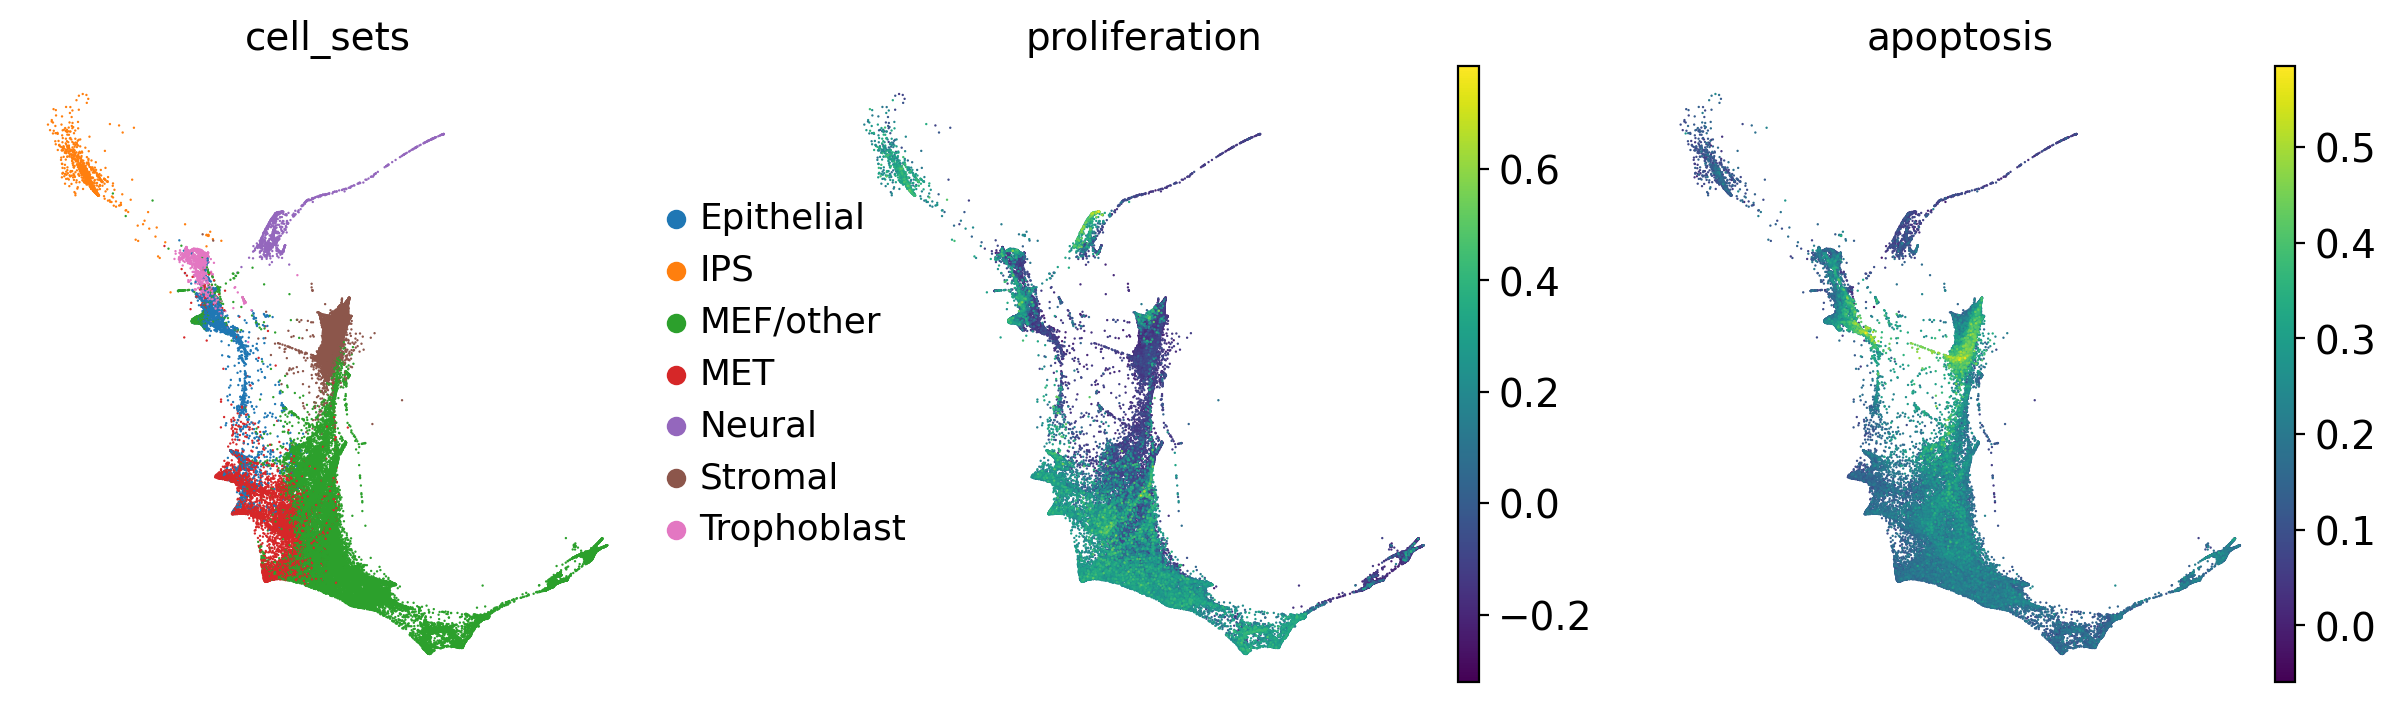

In [8]:
# Reconstruct differentiation trajectory across time points using moscot

# With moscot, we couple cells across time points using optimal transport (OT) by setting up the temporal problem.
tp = TemporalProblem(adata)
# Next, we adjust the marginals for cellular growth- and death rates.
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
)
# visualize the proliferation and apoptosis scores
sc.pl.embedding(
    adata, basis="force_directed", color=["cell_sets", "proliferation", "apoptosis"]
)

In [9]:
# Following the original Waddington OT publication, we use local PCAs, computed separately for each pair of time points, to calulate distances among cells.
tp = tp.prepare(time_key="day")

INFO     Ordering Index(['D1.5_Dox_C1_ACTATCTTCTGCGGCA-1', 'D2.5_Dox_C1_CAGCCGACAATCCGAT-1',                       
                'D2.5_Dox_C2_CATCGAAAGCCAGTTT-1', 'D8.25_serum_C2_CGGAGTCTCACGCATA-1',                             
                'D18_serum_C1_TATTACCTCCCAACGG-1', 'D15.5_serum_C2_AAATGCCGTTGTACAC-1',                            
                'D8_Dox_C2_CAAGAAATCAGTGTTG-1', 'D2_Dox_C2_AATCCAGTCCCTCTTT-1',                                    
                'D8.5_serum_C2_TAAGAGAGTAGGAGTC-1', 'D15.5_serum_C1_CGGACACGTCTCTTTA-1',                           
                ...                                                                                                
                'D2_Dox_C2_TCCACACTCGTCACGG-1', 'D18_serum_C2_CTGATCCCAAGGGTCA-1',                                 
                'D6.5_Dox_C2_CACTCCATCTCCGGTT-1', 'D15_serum_C2_TTAGGACTCGCATGAT-1',                               
                'D6_Dox_C1_GTAACTGTCGACGGAA-1', 'D3.5_Dox_C2_CCTTTCTTCCC

In [10]:
# We solve one OT problem per time point pair, probabilistically matching early to late cells.

tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")
# Above, epsilon and tau_a control the amount of entropic regularization and unbalancedness on the source marginal, respectively. 
# Higher entropic regularization speeds up the optimization and improves statistical properties of the solution [Cuturi, 2013]; 
# unbalancedness makes the solution more robust with respect to uncertain cellular growth rates and biased cell sampling

INFO     Solving `38` problems                                                                                     
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(561, 489)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1785, 1756)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1620, 2118)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(755, 762)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(685, 954)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1749, 1641)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(866, 881)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(919,

In [11]:
# Set up the RealTimeKernel

tmk = RealTimeKernel.from_moscot(tp)

In [12]:
# to get from OT transport maps to a markov chain:
# 1. we sparsify OT transport maps by removing entries below a certain threshold; entropic regularization yields dense matrices which would make CellRank analysis very slow.
# 2. we use OT transport maps and molecular similarity to model transitions across and within time points, respectively.
# 3. we row-normalize the resulting cell-cell transition matrix (including all time points) and construct the Markov chain.

tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

100%|██████████| 38/38 [00:00<00:00, 42120.39time pair/s]


Using automatic `threshold=0.0`


RealTimeKernel[n=41473, threshold='auto', self_transitions='all']

Simulating `100` random walks of maximum length `500`


100%|██████████| 100/100 [00:34<00:00,  2.88sim/s]

    Finish (0:00:34)


Plotting random walks


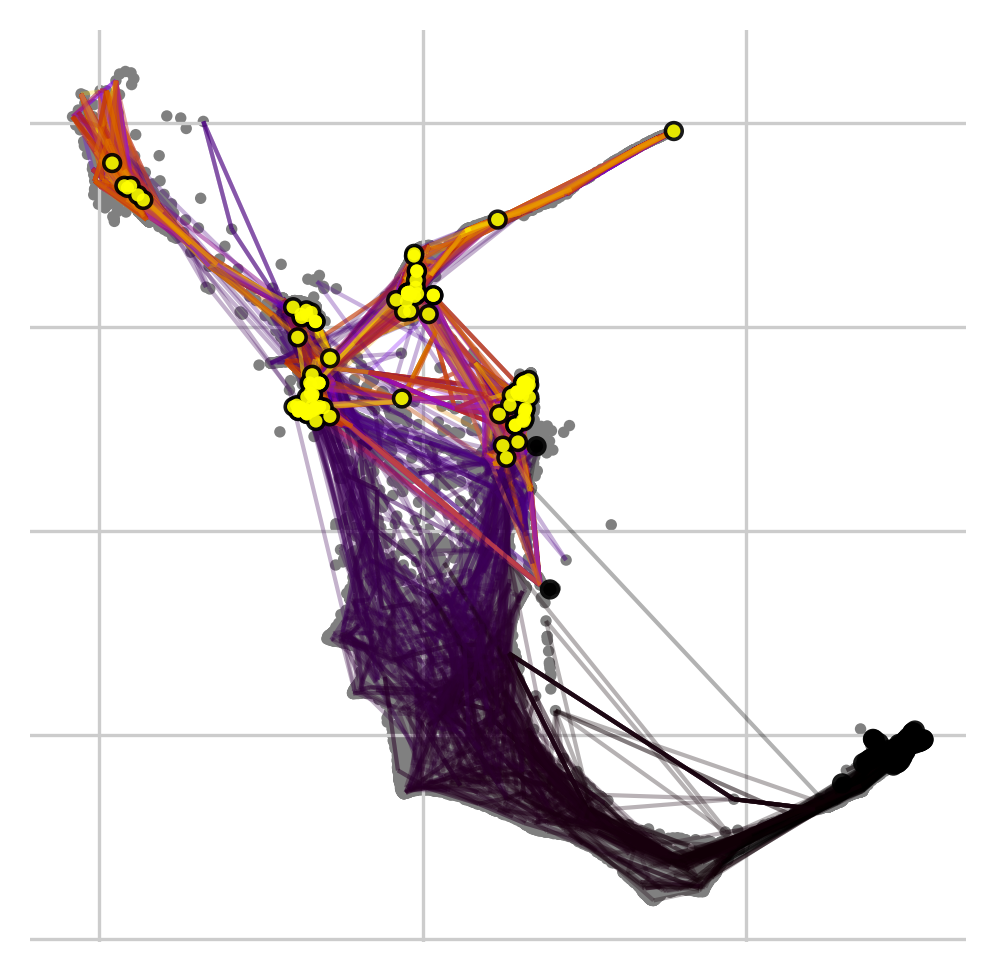

In [13]:
# Visualize the recovered dynamics by sampling random walks.
tmk.plot_random_walks(
    max_iter=500,
    start_ixs={"day": 0.0},
    basis="force_directed",
    seed=0,
    dpi=150,
    size=30,
)
# Black and yellow dots denote random walks starting and finishing points, respectively.

Computing flow from `MEF/other` into `2` cluster(s) in `38` time points
Plotting flow from `MEF/other` into `2` cluster(s) in `38` time points


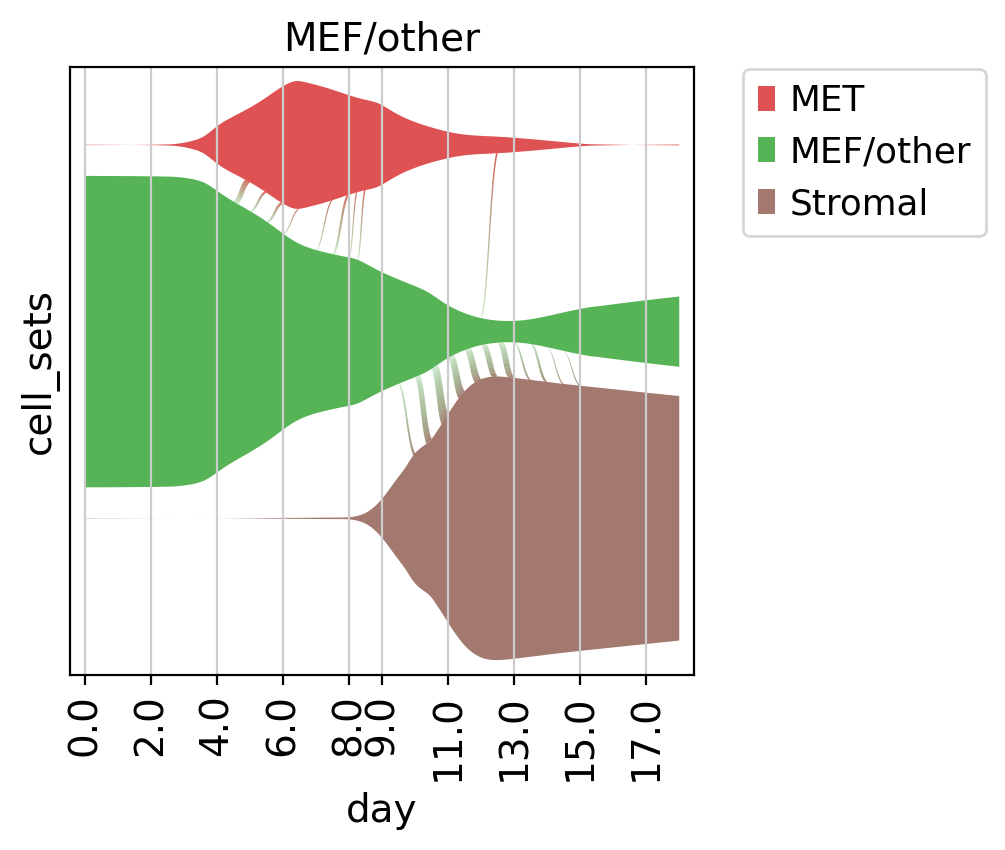

In [14]:
# plot the probability mass flow in time

ax = tmk.plot_single_flow(
    cluster_key="cell_sets",
    time_key="day",
    cluster="MEF/other",
    min_flow=0.1,
    xticks_step_size=4,
    show=False,
    clusters=["MEF/other", "MET", "Stromal"],
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)